# Social Representations and Boundaries of Humor: A focus on Gender roles

## Research questions: 

1) How are men and women depicted in New Yorker cartoons and captions, and do these depictions reflect traditional gender roles or stereotypes?

2) How does audience response (e.g., votes or winning captions) relate to gendered content—do captions about one gender receive more positive attention, and does this reinforce or challenge stereotypes?

## Structure:

### 0. Method to detect gender

Detect gendered references in captions/descriptions and assign a gender to each of them (male, female, both, neutral). 

*Method*: Found two gender lists that contains gendered word. I wanted a longer list so I manually augmented it with universal gendered word and contextual gender markers. Then I added words based on what words are actually on the dataset.

### 1. General distributions

1) Overall presence of gender in captions and image descriptions (barplot)

2) top gendered words -> BOW matrix (histogram)

### 2. How are men/women depicted in the captions

1) Find the top words associated with each gender (wordclouds)

2) Find topic related to man and woman (topic detection)

3) Are men/women seen positively/negatively? (Does it evolve over time?) (sentiment analysis)


### 3. Audience response to gender related captions ?

1. Are captions mentionning gender more funny ? (funnyness score + t-test: $H_0$: There are no difference in funiness between gendered caption and non gendered captions. If refuted: $H_0$: There are no difference in funiness between male gendered caption and female gendered caption. *hope it's refuted*)

2. Does it change over time ?

## Initialisation of the root path

In [2]:
from pathlib import Path
import sys

def warning1(text): print("WARNING!!! ", text)
ACTIVATE_PRINTS = False

# Get correct root path
try:
    root = Path(__file__).resolve().parent
except NameError:
    root = Path.cwd()  # fallback for Jupyter notebooks

while root.parent != root:
    if all((root / marker).exists() for marker in [".git", "README.md", "results.ipynb"]):
        break
    root = root.parent

# Fallback in case nothing found
if not any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb"]):
    print("Could not locate project root — defaulting to current working directory")
    root = Path.cwd()

if ACTIVATE_PRINTS: print(f"Root folder detected at: {root}")

# Ensure importability of the project
if str(root) not in sys.path:
    sys.path.insert(0, str(root))

print(root)

d:\GitHub\ada-2025-project-adacore42


## Imports

In [3]:
# working librairies
import os
import pickle
import csv

sys.path.append(os.path.abspath(".."))

# utils
from src.utils.general_utils import *

# class with functions
from src.models.gender_analysis import GenderAnalysis

# basics
import pandas as pd
import numpy as np

# other
from collections import Counter

# plots
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# text processing libraries
import nltk
import spacy

## Loading the data



In [4]:
stored_dataprep_pkl_path = r'D:\GitHub\ada-2025-project-adacore42\data\data_prepared.pkl'

with open(stored_dataprep_pkl_path, 'rb') as f:
    data = pickle.load(f)

In [5]:
# Extract the objects in the pickle

# dataA est une liste de DataFrames pandas (ou un objet similaire, comme un dictionnaire de DataFrames). Chaque élément de la liste contient un DataFrame avec 7 colonnes et un nombre variable de lignes.
dataA = data['dataA']
# dataC est un DataFrame de métadonnées de tous les cartoon contests.
dataC = data['dataC']
dataA_startID = data['dataA_startID']
dataA_endID = data['dataA_endID']
dataC_lastGoodID = data['dataC_lastGoodID']

In [6]:
dataA_removed, dataC_removed = drop_NaN(dataA, dataC)

In [7]:
print(f"Length dataA: {len(dataA_removed)}\nShape dataC: {dataC_removed.shape}")

Length dataA: 240
Shape dataC: (240, 9)


In [8]:
ga = GenderAnalysis()

## Step 0: Augment the gendered lists

Include male and female names: asked to chatGPT to produce me a list (based on Social Security Administration data)

Include public figures: asked chatGPT for 50 male and female celebrities

The list can be found in gender_analysis.py

## Step 1: Detect gender

Use gender lexicons, but we need to define them first. 

For P2, I used two small lists with common gendered terms. For P3 I want to extend them based on what what terms are used in the contest!

### In the image description

In [9]:
# detect gender in the cartoon descriptions
dataC0 = dataC_removed.copy(deep=True)
dataC1 = ga.get_metadata(dataC0)

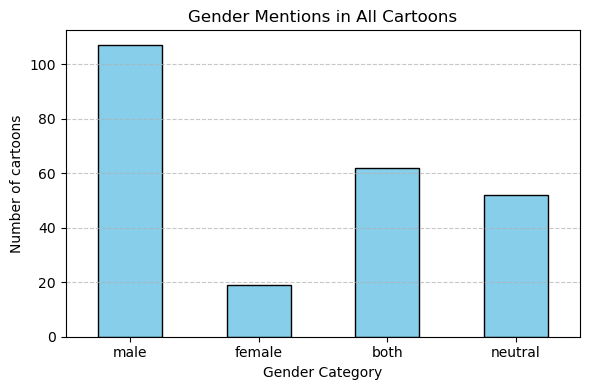

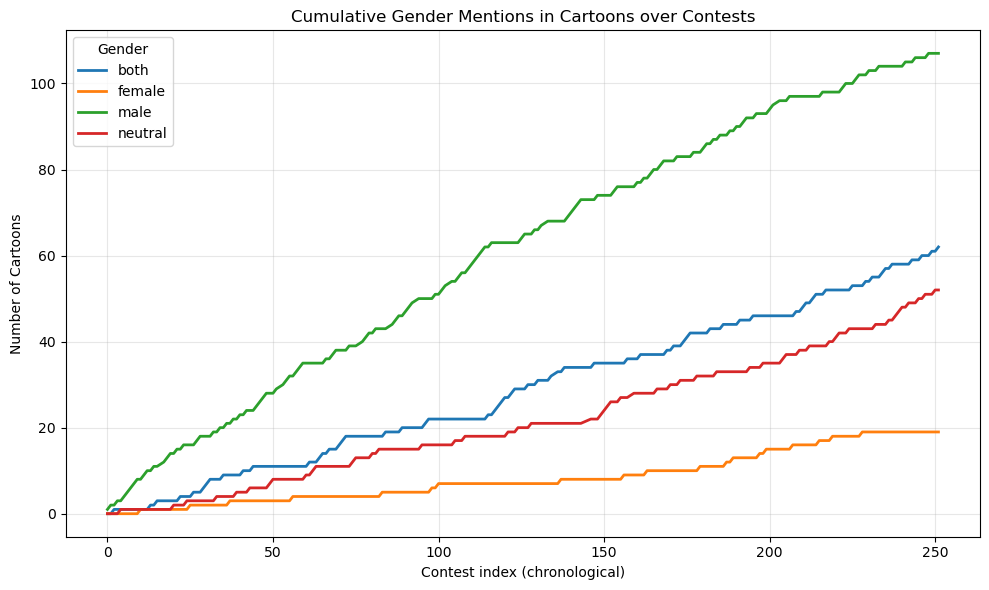

In [10]:
# How often men/women appear in a cartoon ?

# Overall distribution of gender over all the cartoons.
gender_image = dataC1['gender_mention']

# Count frequency
gender_counts = gender_image.value_counts().sort_index()

# Plot Overall counts
ga.plot_overall_counts(
    gender_counts,
    title="Gender Mentions in All Cartoons",
    xlabel="Gender Category",
    ylabel="Number of cartoons"
)

# Evolution over time
df = pd.DataFrame({"contest_index": range(0, len(dataC1)),
                   "gender_mention": dataC1['gender_mention']})

# Count mentions per contest (here each row = one contest)
counts = pd.get_dummies(df["gender_mention"]).cumsum()

# Plot cumulative counts
ga.plot_cumulative_mentions(
    counts,
    title="Cumulative Gender Mentions in Cartoons over Contests",
    xlabel="Contest index (chronological)",
    ylabel="Number of Cartoons",
    legend_title="Gender"
)

### In the captions

In [11]:
# Don't run again
dataTop = ga.get_Top_captions(dataA_removed)

# Results were saved here: 
STORED_DATAPREP_PKL_PATH = r'D:\GitHub\ada-2025-project-adacore42\_Other\amelie_analysis\processed_captions.pkl'
with open(STORED_DATAPREP_PKL_PATH, "wb") as f:
    pickle.dump(dataTop, f)

In [12]:
STORED_DATACAPTION_PKL_PATH = r'D:\GitHub\ada-2025-project-adacore42\_Other\amelie_analysis\processed_captions.pkl'
with open(STORED_DATACAPTION_PKL_PATH, "rb") as f:
    data_caption = pickle.load(f)

In [14]:
# # How often men/women are mentionned in captions

# overall_counts, pivoted = ga.distribution_captions(count)

# # In the plots I don't show the neutral, because it is a huge number compared
# # to the other categories

# # Plot Overall counts
# ga.plot_overall_counts(
#     overall_counts,
#     title="Overall Presence of Gender Mentions in the top 10 Captions",
#     xlabel="Gender Category",
#     ylabel="Number of Captions",
#     neutral = False
# )

# # Evolution over time
# cumulative = pivoted.cumsum()

# # Plot cumulative counts
# ga.plot_cumulative_mentions(
#     cumulative,
#     title="Cumulative Gender Mentions in Top 10 Captions per Contest",
#     xlabel="Contest index (chronological)",
#     ylabel="Number of Captions",
#     legend_title="Gender",
#     neutral = False
# )

### Verbs and adjectives associated with genders

In [ ]:
# men = data_caption[0].groupby('caption').filter(lambda x: x['gender_mention'] == 'male')

In [65]:
nlp = spacy.load("en_core_web_sm")

verbs_male = Counter()
verbs_female = Counter()
adjs_male = Counter()
adjs_female = Counter()

for contest in data_caption:

    male_caps   = contest.loc[contest['gender_mention'] == 'male',   'caption'].tolist()
    female_caps = contest.loc[contest['gender_mention'] == 'female', 'caption'].tolist()

    # process male captions in batch
    for doc in nlp.pipe(male_caps):
        for token in doc:
            if token.pos_ == "VERB":
                verbs_male[token.lemma_] += 1
            elif token.pos_ == "ADJ":
                adjs_male[token.lemma_] += 1

    # process female captions in batch
    for doc in nlp.pipe(female_caps):
        for token in doc:
            if token.pos_ == "VERB":
                verbs_female[token.lemma_.lower()] += 1
            elif token.pos_ == "ADJ":
                adjs_female[token.lemma_.lower()] += 1
    break

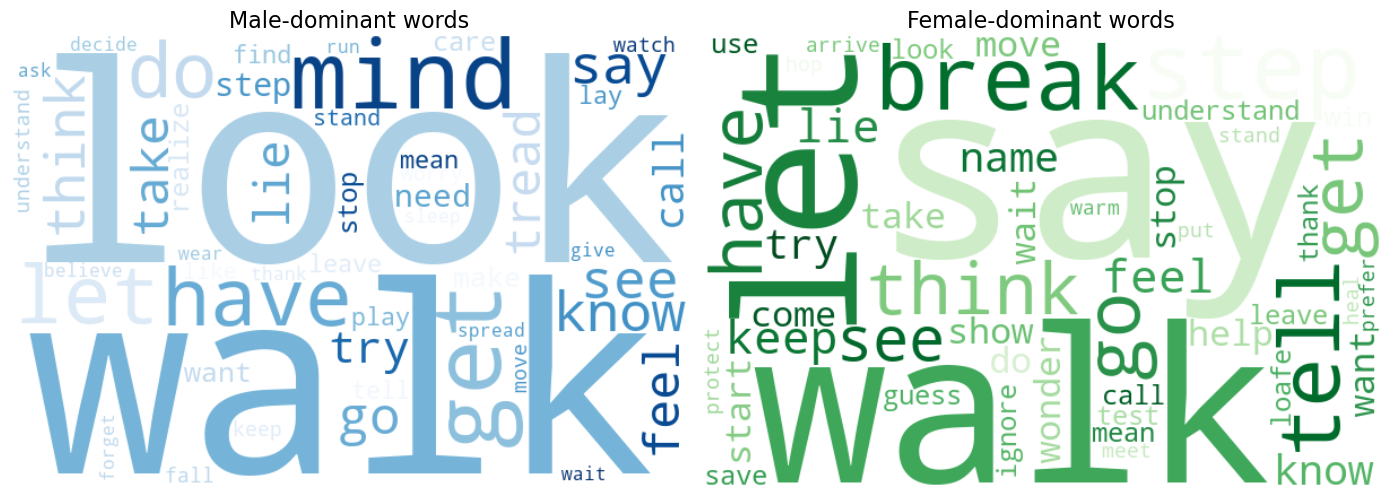

In [68]:
from wordcloud import WordCloud

# --- Generate the word clouds ---
male_cloud = WordCloud(
    width=600,
    height=400,
    background_color='white',
    colormap='Blues',
    max_words=50
).generate_from_frequencies(verbs_male)

female_cloud = WordCloud(
    width=600,
    height=400,
    background_color='white',
    colormap='Greens',
    max_words=50
).generate_from_frequencies(verbs_female)

ga.plot_wordclouds(male_cloud, female_cloud)

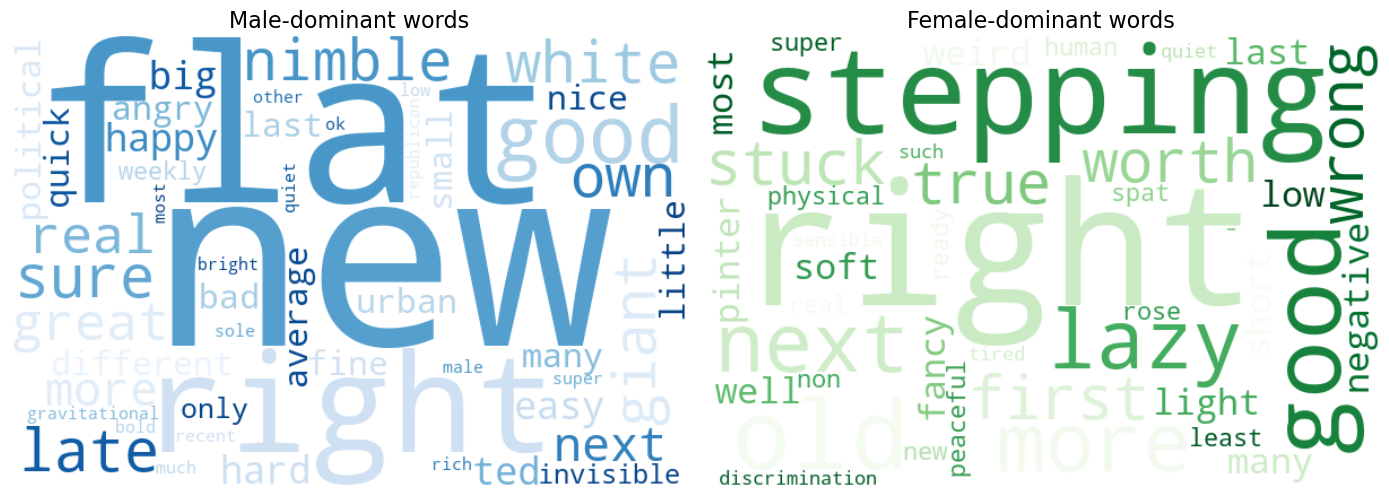

In [69]:
# --- Generate the word clouds ---
male_cloud = WordCloud(
    width=600,
    height=400,
    background_color='white',
    colormap='Blues',
    max_words=50
).generate_from_frequencies(adjs_male)

female_cloud = WordCloud(
    width=600,
    height=400,
    background_color='white',
    colormap='Greens',
    max_words=50
).generate_from_frequencies(adjs_female)

ga.plot_wordclouds(male_cloud, female_cloud)

### NEXT

## Other codes

In [23]:
male_terms = [
            'guy', 'spokesman', 'chairman', "men's", 'men', 'him', "he's", 'his', 'boy',
            'boyfriend', 'boyfriends', 'boys', 'brother', 'brothers', 'dad', 'dads',
            'dude', 'father', 'fathers', 'fiance', 'gentleman', 'gentlemen', 'god',
            'grandfather', 'grandpa', 'grandson', 'groom', 'he', 'himself', 'husband',
            'husbands', 'king', 'male', 'man', 'mr', 'nephew', 'nephews', 'priest',
            'prince', 'son', 'sons', 'uncle', 'uncles', 'waiter', 'widower', 'widowers',
            'congressman',

            # --- Added universal & contextual male terms ---
            'bloke', 'chap', 'fella', 'gent', 'sir', 'lad', 'lads',
            'manliness', 'masculine', 'boyhood',
            'father-in-law', 'stepfather', 'stepson',
            'godfather', 'old man',
            'bachelor', 'groomsman',
            'kings',
            'monk', 'wizard',
            'policeman', 'fireman', 'salesman', 'businessman', 'workman',

            # --- Public figures ---
            "bush", "sanders",
            "einstein", "hitchcock", "bansky", "kanye", "obama","biden","trump","putin","zelenskyy",
            "macron","schwarzenegger","clooney","hanks","dicaprio",
            "pitt","depp","cruise","stallone","eastwood","gosling","carey","seinfeld","rock","chappelle",
            "sandler","springsteen","dylan","cobain","mars","drake","sheeran","mccartney","lennon",
            "jagger","bale","damon","affleck","reynolds","washington","freeman","jackson","smith","murphy",
            "reeves","keaton","downey","ruffalo","leno","colbert","stewart","oppenheimer","gates","musk"


            # --- 200 Most Popular American male names ---
            "james","robert","john","michael","david","william","richard","joseph","thomas","charles",
            "christopher","daniel","matthew","anthony","mark","donald","steven","paul","andrew","joshua",
            "kenneth","kevin","brian","george","edward","ronald","timothy","jason","jeffrey","ryan",
            "jacob","gary","nicholas","eric","jonathan","stephen","larry","justin","scott","brandon",
            "benjamin","samuel","gregory","alexander","frank","patrick","raymond","jack","dennis","jerry",
            "tyler","aaron","jose","adam","nathan","henry","douglas","zachary","peter","kyle",
            "walter","ethan","jeremy","harold","keith","christian","roger","noah","gerald","carl",
            "terry","sean","austin","arthur","lawrence","jesse","dylan","bryan","joe","jordan",
            "billy","bruce","albert","willie","gabriel","logan","alan","juan","wayne","roy",
            "ralph","randy","eugene","vincent","bobby","russell","louis","philip","johnny","riley",
            "victor","mason","dale","brett","caleb","curtis","phillip","nathaniel","rodney","cody",
            "joel","craig","tony","evan","shawn","wesley","alex","travis","chad","derrick",
            "stanley","leonard","connor","oscar","xavier","miguel","edwin","martin","emmanuel","jay",
            "clifford","herman","seth","edgar","mario","frederick","allen","tyrone","max","aiden",
            "colton","hector","jon","spencer","rick","clarence","malik","leo","dustin","maurice",
            "dominic","hayden","troy","gordon","marshall","abel","andre","lawson","reed","ramon",
            "lance","casey","terrence","francis","trevor","jared","marco","darren","eli","ben",
            "rafael","don","diego","romeo","ruben","clayton","carlos","kirk","brayden","ronnie",
            "felix","jimmy","asher","camden","harvey","brendan","tristan","dean","parker","francisco",
            "ivan","milo","ted"
        ]

In [21]:
dataA[0]['caption'][3901]

"This has 'Alice in Wonderland' beat by a mile."

In [15]:
# load nlp from spacy
nlp = spacy.load("en_core_web_sm")

In [20]:
example = data_caption[0]['caption'].values[0]
example

"i'm a congressman--obstruction is my job."

In [21]:
example = data_caption[0]['caption'].values[0]
doc = nlp(example)

In [24]:
tokens = [token.text for token in doc]
print(tokens)

['This', 'has', "'", 'Alice', 'in', 'Wonderland', "'", 'beat', 'by', 'a', 'mile', '.']


In [25]:
pos_tagged = [(token.text, token.pos_) for token in doc]
print(pos_tagged)

[('This', 'PRON'), ('has', 'VERB'), ("'", 'PUNCT'), ('Alice', 'PROPN'), ('in', 'ADP'), ('Wonderland', 'PROPN'), ("'", 'PUNCT'), ('beat', 'NOUN'), ('by', 'ADP'), ('a', 'DET'), ('mile', 'NOUN'), ('.', 'PUNCT')]


In [26]:
for ent in doc.ents:
    print(ent.text, ent.label_)

Alice PERSON
Wonderland GPE
a mile QUANTITY


In [ ]:
def extract_nouns(dataA):
    nlp = spacy.load("en_core_web_sm")
    nouns = Counter()

    for idx in range(len(dataA)):
        captions = dataA[idx].caption

    for text in captions:
        doc = nlp(text)
        for token in doc:
            if token.pos_ in ["NOUN"]:  # common + proper nouns
                nouns[token.lemma_] += 1
    return nouns

def extract_proper_nouns(dataA):

    nlp = spacy.load("en_core_web_sm")
    proper_nouns = Counter()

    for idx in range(len(dataA)):
        captions = dataA[idx].caption

        for text in captions:
            doc = nlp(text)
            for ent in doc.ents:
                if ent.label_ == 'PERSON':
                    proper_nouns[ent.text] += 1

    return proper_nouns

In [61]:
# load nlp from spacy
nlp = spacy.load("en_core_web_sm")

verbs_male = []
verbs_female = []
adjs_male = []
adjs_female = []

# Create two separated document: one with all the male and the other with all of the female captions
for contest in data_caption:
    # initialize lists that keep track of type of words
    verb_male = []
    verb_female = []
    adj_male = []
    adj_female = []


    # find in each caption that are labeled as male the verb and ajdectives
    male_captions = contest[contest['gender_mention'] == 'male'].caption.values
    for caption in male_captions:
        doc = nlp(caption)
        for token in doc:
            if token.pos_ == 'VERB':
                verb_male.append(token.text)
            elif token.pos_ == 'ADJ':
                adj_male.append(token.text)


    # find in each caption that are labeled as female the verb and ajdectives
    female_captions = contest[contest['gender_mention'] == 'female'].caption.values
    for caption in female_captions:
        doc = nlp(caption)
        for token in doc:
            if token.pos_ == 'VERB':
                verb_female.append(token.text)
            elif token.pos_ == 'ADJ':
                adj_female.append(token.text)

    
    verbs_male.append(verb_male)
    verbs_female.append(verb_female)
    adjs_male.append(adj_male)
    adjs_female.append(adj_female)
    break